<a href="https://colab.research.google.com/github/AlfiRam/Computer-Vision-Final-Project-Fire-Detection/blob/main/UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install visualkeras

Note: you may need to restart the kernel to use updated packages.


0. Import Dependencies

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

0.1 Seeding

In [ ]:
seed = 42
random.seed = seed
np.random.seed = seed
tf.seed = seed

1. Data Generator

In [ ]:
class DataGen(keras.utils.Sequence):
    def __init__(self, image_paths, mask_paths, batch_size=8, image_size=256):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()

    def __load__(self, image_path, mask_path):
        # Reading Image
        image = cv2.imread(image_path, 1)
        image = cv2.resize(image, (self.image_size, self.image_size))

        mask = np.zeros((self.image_size, self.image_size))

        if mask_path:
            _mask_image = cv2.imread(mask_path, -1)
            _mask_image = cv2.resize(_mask_image, (self.image_size, self.image_size))

            if len(_mask_image.shape) == 3:
                _mask_image = _mask_image[:, :, 0]  # Convert 3-channel mask to 1-channel

            mask = np.maximum(mask, _mask_image)

        # Normalizing
        image = image / 255.0
        mask = mask / 255.0

        return image, mask

    def __getitem__(self, index):
        if (index + 1) * self.batch_size > len(self.image_paths):
            self.batch_size = len(self.image_paths) - index * self.batch_size

        files_batch = zip(
            self.image_paths[index * self.batch_size: (index + 1) * self.batch_size],
            self.mask_paths[index * self.batch_size: (index + 1) * self.batch_size]
        )

        image = []
        mask = []

        for image_path, mask_path in files_batch:
            _img, _mask = self.__load__(image_path, mask_path)
            image.append(_img)
            mask.append(_mask)

        image = np.array(image)
        mask = np.array(mask)

        return image, mask



    def on_epoch_end(self):
        pass

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / float(self.batch_size)))


1.1 Data Path Generator

1.1.1 Using Dictionary

In [ ]:
image_paths = []
mask_paths = []

In [ ]:
mask_path_dict = {
    'kaggle_fire_mask': '/Users/auliaazmi/Downloads/archive/Segmentation_Mask/Fire',
    'Fire_Anot_Dataset': '/Users/auliaazmi/Downloads/FireAnnotationDataset'
}

image_path_dict = {
    'kaggle_fire_rgb': '/Users/auliaazmi/Downloads/archive/Image/Fire',
    'Fire_Seg_Dataset': '/Users/auliaazmi/Downloads/FireSegmentationDataset'
}

# Populating image_paths
for key, path in image_path_dict.items():
    for root, dirs, files in os.walk(path):
        for file in files:
            if file == '.DS_Store':
                continue
            # Check if file has a valid image extension
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_path = os.path.join(root, file)
                image_paths.append(image_path)

# Populating mask_paths
for key, path in mask_path_dict.items():
    for root, dirs, files in os.walk(path):
        for file in files:
            if file == '.DS_Store':
                continue
            # Check if file has a valid image extension
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                mask_path = os.path.join(root, file)
                mask_paths.append(mask_path)

print("First 5 Image Paths:")
for image_path in image_paths[:5]:
    print(image_path)

print("\nFirst 5 Mask Paths:")
for mask_path in mask_paths[:5]:
    print(mask_path)

First 5 Image Paths:

First 5 Mask Paths:


1.1.2 Using Variables

In [ ]:
kaggle_fire_rgb = '/Users/auliaazmi/Downloads/archive/Image/Fire'
kaggle_fire_mask = '/Users/auliaazmi/Downloads/archive/Segmentation_Mask/Fire'
Fire_Seg_Dataset = '/Users/auliaazmi/Downloads/FireSegmentationDataset'
Fire_Anot_Dataset = '/Users/auliaazmi/Downloads/FireAnnotationDataset'

In [ ]:
# Populating image_paths
for root, dirs, files in os.walk(kaggle_fire_rgb):
    for file in files:
        if file == '.DS_Store':
            continue
        # Check if file has a valid image extension
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(root, file)
            image_paths.append(image_path)

# Populating mask_paths
for root, dirs, files in os.walk(kaggle_fire_mask):
    for file in files:
        if file == '.DS_Store':
            continue
        # Check if file has a valid image extension
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            mask_path = os.path.join(root, file)
            mask_paths.append(mask_path)

# Populating image_paths
for root, dirs, files in os.walk(Fire_Seg_Dataset):
    for file in files:
        if file == '.DS_Store':
            continue
        # Check if file has a valid image extension
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(root, file)
            image_paths.append(image_path)

# Populating mask_paths
for root, dirs, files in os.walk(Fire_Anot_Dataset):
    for file in files:
        if file == '.DS_Store':
            continue
        # Check if file has a valid image extension
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            mask_path = os.path.join(root, file)
            mask_paths.append(mask_path)

print("First 5 Image Paths:")
for image_path in image_paths[:5]:
    print(image_path)

print("\nFirst 5 Mask Paths:")
for mask_path in mask_paths[:5]:
    print(mask_path)

First 5 Image Paths:

First 5 Mask Paths:


1.1.3 Sorting Paths

In [ ]:
image_paths.sort()
mask_paths.sort()

1.2 Data Gen Creation

In [ ]:
image_size = 64
epochs = 1
batch_size = 10
val_data_size = 100

In [ ]:
from sklearn.model_selection import train_test_split

# Splitting image paths
image_paths_train, image_paths_val = train_test_split(image_paths, test_size=0.2, random_state=42)

# Splitting mask paths
mask_paths_train, mask_paths_val = train_test_split(mask_paths, test_size=0.2, random_state=42)

# Printing the results
print("Training Image Paths:")
for image_path in image_paths_train[:5]:
    print(image_path)

print("\nValidation Image Paths:")
for image_path in image_paths_val[:5]:
    print(image_path)

print("\nTraining Mask Paths:")
for mask_path in mask_paths_train[:5]:
    print(mask_path)

print("\nValidation Mask Paths:")
for mask_path in mask_paths_val[:5]:
    print(mask_path)

Training Image Paths:
/Users/auliaazmi/Downloads/archive/Image/Fire/Img_27879.jpg
/Users/auliaazmi/Downloads/archive/Image/Fire/Img_7050.jpg
/Users/auliaazmi/Downloads/archive/Image/Fire/Img_23261.jpg
/Users/auliaazmi/Downloads/archive/Image/Fire/Img_8562.jpg
/Users/auliaazmi/Downloads/archive/Image/Fire/Img_18184.jpg

Validation Image Paths:
/Users/auliaazmi/Downloads/archive/Image/Fire/Img_25239.jpg
/Users/auliaazmi/Downloads/archive/Image/Fire/Img_16433.jpg
/Users/auliaazmi/Downloads/archive/Image/Fire/Img_22497.jpg
/Users/auliaazmi/Downloads/archive/Image/Fire/Img_8308.jpg
/Users/auliaazmi/Downloads/archive/Image/Fire/Img_22159.jpg

Training Mask Paths:
/Users/auliaazmi/Downloads/archive/Segmentation_Mask/Fire/Img_27879.jpg
/Users/auliaazmi/Downloads/archive/Segmentation_Mask/Fire/Img_7050.jpg
/Users/auliaazmi/Downloads/archive/Segmentation_Mask/Fire/Img_23261.jpg
/Users/auliaazmi/Downloads/archive/Segmentation_Mask/Fire/Img_8562.jpg
/Users/auliaazmi/Downloads/archive/Segmentation_

In [ ]:
train_steps = len(image_paths_train)//batch_size
valid_steps = len(image_paths_val)//batch_size

In [ ]:
train_gen = DataGen(image_paths_train, mask_paths_train, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(image_paths_val, mask_paths_val, image_size=image_size, batch_size=batch_size)

(10, 64, 64, 3) (10, 64, 64)


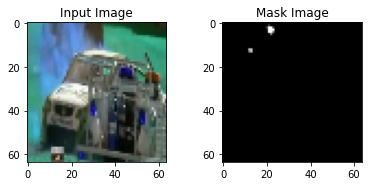

In [ ]:
gen = DataGen(image_paths_train, mask_paths_train, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)
print(x.shape, y.shape)

r = random.randint(0, len(x)-1)

fig, ax = plt.subplots(1, 2)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax[0].imshow(x[r])
ax[0].set_title("Input Image")

ax[1].imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")
ax[1].set_title("Mask Image")

plt.show()


2.1 Model UNet

In [ ]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [ ]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))

    p0 = inputs
    c1, p1 = down_block(p0, f[0])  # 128 --> 64
    c2, p2 = down_block(p1, f[1])  # 64  --> 32
    c3, p3 = down_block(p2, f[2])  # 32  --> 16
    c4, p4 = down_block(p3, f[3])  # 16  --> 8

    bn = bottleneck(p4, f[4])

    u1 = up_block(bn, c4, f[3])  # 8  --> 16
    u2 = up_block(u1, c3, f[2])  # 16 --> 32
    u3 = up_block(u2, c2, f[1])  # 32 --> 64
    u4 = up_block(u3, c1, f[0])  # 64 --> 128

    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model


In [ ]:
model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_57 (Conv2D)             (None, 64, 64, 16)   448         ['input_4[0][0]']                
                                                                                                  
 conv2d_58 (Conv2D)             (None, 64, 64, 16)   2320        ['conv2d_57[0][0]']              
                                                                                                  
 max_pooling2d_12 (MaxPooling2D  (None, 32, 32, 16)  0           ['conv2d_58[0][0]']              
 )                                                                                          

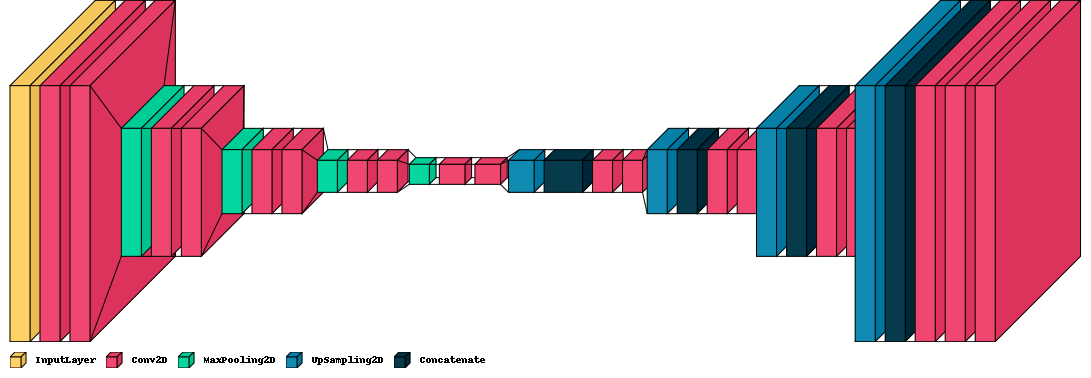

In [ ]:
import visualkeras
visualkeras.layered_view(model, legend=True)

In [ ]:
len(image_paths_train)

48230

In [ ]:
len(mask_paths_train)

48230

In [ ]:
model.fit(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps,
          validation_steps=valid_steps, epochs=epochs)

4823/4823 [==============================] - 990s 205ms/step - loss: 0.0346 - acc: 0.9703 - val_loss: 0.0248 - val_acc: 0.9721


In [ ]:
from tensorflow.keras.models import Model

In [ ]:
model.save_weights("UNetWAv2.h5")

In [ ]:
model.save('UNetAv2.h5')